# Generate samples for the Deforestation Paper with multi-temporal stack

In [1]:
import sys
import os
# import pylab as plt
import numpy as np
# from matplotlib.colors import ListedColormap
# from osgeo import gdal
# from osgeo import ogr
from importlib import reload
# import skimage

sys.path.insert(0, '../../src')
# import deepleeo.dataset.data_augment as dtaug
import deepleeo.dataset.rasterizer as rstzr
import deepleeo.dataset.preprocessor as prep
import deepleeo.dataset.chipsGenerator as cg
# import deepleeo.utils.filesystem as fs
import deepleeo.utils.geofunctions as gf
import deepleeo.utils.visualization as vis

# reload(dtaug)
reload(rstzr)
reload(prep)
reload(cg)
# reload(fs)
reload(gf)
reload(vis)

%matplotlib inline

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Input Files
DATA_DIR = "/home/raian/doutorado/Dados/generated"
shape_file = os.path.join(DATA_DIR, 'Prodes_mosaic.shp')
raster_file = os.path.join(DATA_DIR, "stacked_mosaic_2015_2016.tif")

classes_of_interest = ["d2016"]
non_class = "not_deforestation"
class_column = "class_name"

# Output Files
output_path = DATA_DIR
# fs.mkdir(output_path)
out_labels = os.path.join(output_path, "labels.tif")
output_shp = os.path.join(output_path, "samples.shp")
output_npz = os.path.join(output_path, "dataset_286x286_timesstack-2015-2016.npz")

number_of_samples = 5000
chip_size = 286

## Rasterize the input shape file

In [3]:
rasterizer = rstzr.Rasterizer(shape_file,
                             raster_file,
                             class_column,
                             classes_interest=classes_of_interest,
                             non_class_name=non_class)

rasterizer.collect_class_names()
rasterizer.rasterize_layer()
class_names = rasterizer.get_class_names()
rasterized_layer = rasterizer.get_labeled_raster()

In [4]:
rasterizer.save_labeled_raster_to_gtiff(out_labels)

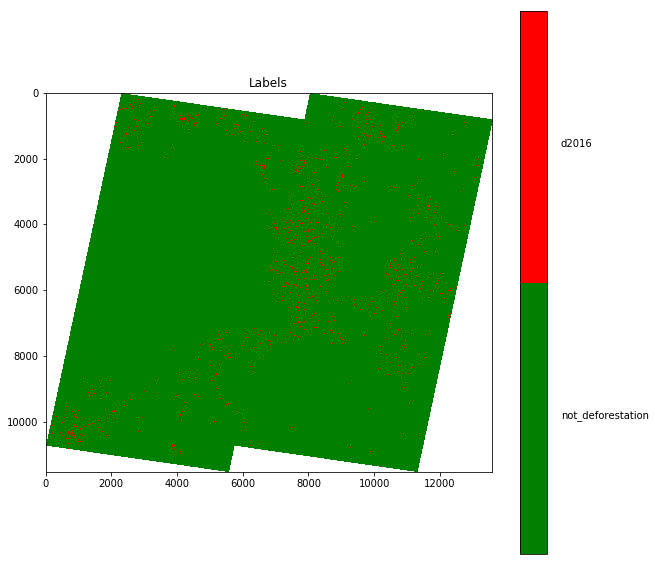

In [5]:
vis.plot_labels(rasterized_layer, class_names, colors=["green", "red"])

# print("UNIQUE: ", np.unique(labels))

SHAPE:  (11534, 13587, 10)


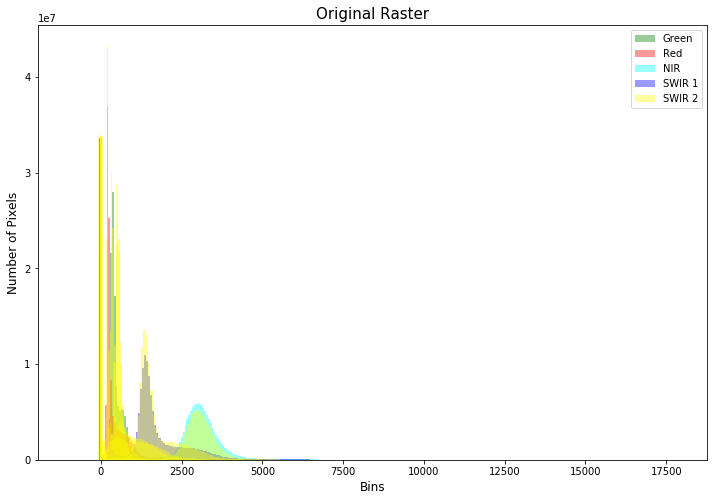

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


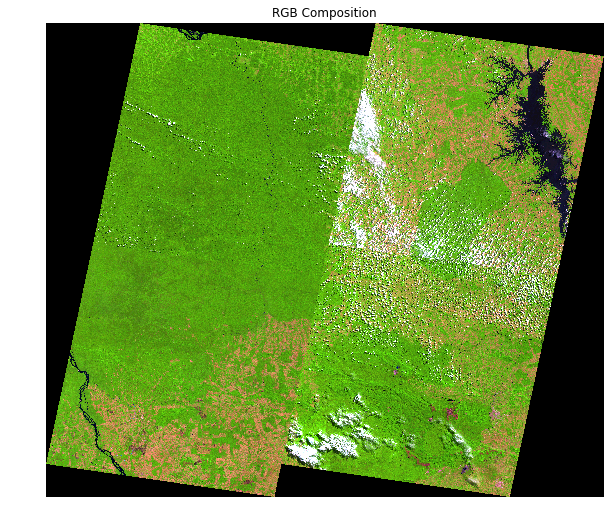

In [6]:
preproc = prep.Preprocessor(raster_file, no_data=-9999)
preproc.set_nodata_value(-10)
original_raster = preproc.get_raster_stacked_raster()
print("SHAPE: ", original_raster.shape)
# print("UNIQUE: ", np.unique(original_raster))

reload(vis)
vis.plot_image_histogram(original_raster, cmap=["green", "red", "cyan", "blue", "yellow"],
                         title="Original Raster", legend=["Green", "Red", "NIR", "SWIR 1", "SWIR 2"])
vis.plot_rgb_img(original_raster, bands=[3,2,1], contrast=True)

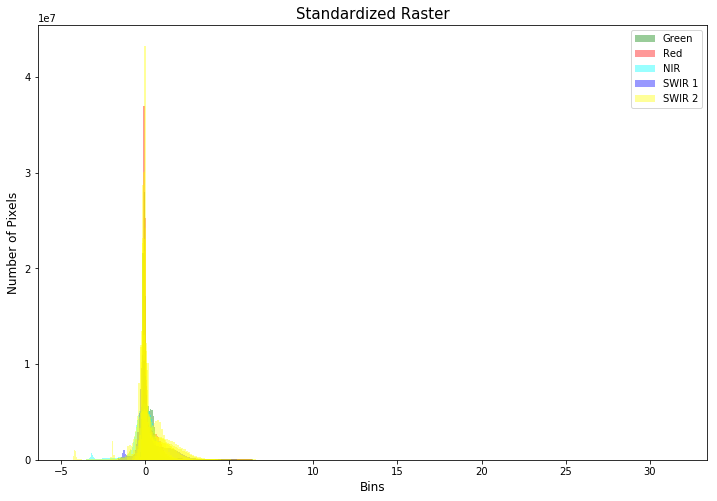

In [7]:
preproc.standardize_image("median_std")
raster_img = preproc.get_raster_stacked_raster()
# print(np.unique(raster_img))
vis.plot_image_histogram(raster_img, cmap=["green", "red", "cyan", "blue", "yellow"],
                         title="Standardized Raster", legend=["Green", "Red", "NIR", "SWIR 1", "SWIR 2"])

In [8]:
reload(cg)
chpGen = cg.ChipsGenerator(raster_img, rasterized_layer, class_names, raster_file)
chpGen.compute_sample_indexes(number_of_samples, class_of_interest='d2016')
chpGen.extract_windows(chip_size)
samples = chpGen.getSamples()
print("Generated ", len(samples["images"]), " image samples.")
print("Generated ", len(samples["labels"]), " label samples.")
chpGen.save_samples_SHP(output_shp)
chpGen.save_samples_NPZ(output_npz)

Generated  5000  image samples.
Generated  5000  label samples.


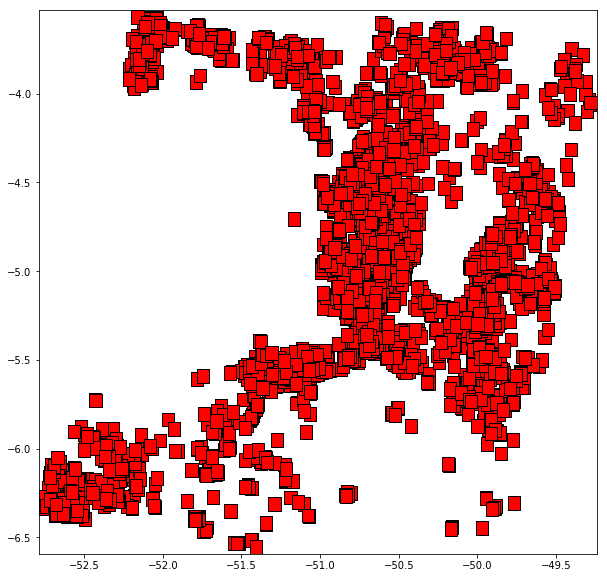

In [9]:
reload(vis)
vis.plot_vector_file(output_shp)